In [1]:
import math
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error


plt.style.use('fivethirtyeight')
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# date parser
parser = lambda date: pd.to_datetime(date, format='%d-%m-%y %H:%M')

# load the dataset
df = pd.read_csv(
    'EVANS-EFCO_final_clean_with_2018.csv', parse_dates=[0],
    index_col=[0], date_parser=parser, engine='python'
)

In [3]:
series = df.loc[:, 'ENERGY CONSUMPTION'].values
series

array([ 7. ,  7. ,  7. , ..., 10. ,  9.5,  9. ])

## Check stationarity of the data

In [4]:
# ADF Test to check if our data is stationary or not
result = adfuller(series, autolag='AIC')

In [5]:
print(f'ADF Statistic: {result[0]}\n')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}\n')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -21.49100685507755

n_lags: 0.0
p-value: 0.0

Critial Values:
   1%, -3.430599102593299
Critial Values:
   5%, -2.8616500960359854
Critial Values:
   10%, -2.5668286008605627


Since P < 0.05 and ADF stat is way lesser than any critical value, our time series is stationary.

## Use grid search to find a suitable model

In [6]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [7]:
print('Examples of parameter combinations for ARIMA...')
print('ARIMA: {}'.format(pdq[1]))
print('ARIMA: {}'.format(pdq[3]))
print('ARIMA: {}'.format(pdq[5]))

Examples of parameter combinations for ARIMA...
ARIMA: (0, 0, 1)
ARIMA: (0, 1, 1)
ARIMA: (1, 0, 1)


In [8]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    mod = sm.tsa.ARIMA(series, order=param)
    results = mod.fit()
    print('ARIMA{} - AIC:{}'.format(param, results.aic))


ARIMA(0, 0, 0) - AIC:260819.4006451146
ARIMA(0, 0, 1) - AIC:237456.74031349208
ARIMA(0, 1, 0) - AIC:203251.30845778226
ARIMA(0, 1, 1) - AIC:201576.3006565532
ARIMA(1, 0, 0) - AIC:202516.70940911974
ARIMA(1, 0, 1) - AIC:201186.29796719062
ARIMA(1, 1, 0) - AIC:201714.7774227533
ARIMA(1, 1, 1) - AIC:201575.68003539517


Since the ***ARIMA(1, 0, 1)*** model has the lowest ***AIC*** score,  it is our chosen model. 

## Fit model and predict

In [9]:
# trainX for model training
# test for testing prediction
train, test = df[:'2017'], df['2018']

In [10]:
model = sm.tsa.ARIMA(train['ENERGY CONSUMPTION'].values, order=(1, 0, 1))
model = model.fit(disp=0)

In [11]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                17544
Model:                     ARMA(1, 1)   Log Likelihood              -67890.931
Method:                       css-mle   S.D. of innovations             11.597
Date:                Mon, 12 Oct 2020   AIC                         135789.862
Time:                        00:01:10   BIC                         135820.952
Sample:                             0   HQIC                        135800.098
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.1793      2.079     29.421      0.000      57.104      65.255
ar.L1.y        0.9688      0.002    491.245      0.000       0.965       0.973
ma.L1.y       -0.2581      0.008    -34.073      0.0

In [12]:
model.save('arima-model.pkl')

In [28]:
from statsmodels.tsa.arima_model import ARIMAResults

load_model = ARIMAResults.load('arima-model.pkl')
print(load_model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                17544
Model:                     ARMA(1, 1)   Log Likelihood              -67890.931
Method:                       css-mle   S.D. of innovations             11.597
Date:                Mon, 12 Oct 2020   AIC                         135789.862
Time:                        00:06:12   BIC                         135820.952
Sample:                             0   HQIC                        135800.098
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.1793      2.079     29.421      0.000      57.104      65.255
ar.L1.y        0.9688      0.002    491.245      0.000       0.965       0.973
ma.L1.y       -0.2581      0.008    -34.073      0.0

In [14]:
predictions = load_model.forecast(len(test))[0]

In [16]:
# Let x and why be the actual and predicted data respectively

x, y = df['2018']['ENERGY CONSUMPTION'].values, predictions

In [17]:
def root_mean_square_error(actual, predicted):
    rmse_score = math.sqrt(mean_squared_error(actual, predicted))
    print('Root Mean Square Error (RMSE) Score: {0:.2f}%'.format(rmse_score))


def mean_average_error(actual, predicted):
    mae_score = (actual - predicted).sum() / len(actual)
    print('Mean Average Error (MAE) Score: {0:.2f}'.format(mae_score))


def mean_average_percentage_error(actual, predicted):
    mape_score = (actual - predicted).sum() / len(actual) * 100
    print('Mean Average Percentage Error (MAPE) Score: {0:.2f}%'.format(mape_score))

In [18]:
# MSE score for prediction
print('Mean Square Error (MSE) Score: {0:.2f}'.format(mean_squared_error(x, y)))

Mean Square Error (MSE) Score: 1077.52


In [19]:
# RMSE score for prediction
root_mean_square_error(x, y)

Root Mean Square Error (RMSE) Score: 32.83%


In [20]:
# MAE score for prediction
mean_average_error(x, y)

Mean Average Error (MAE) Score: -4.47


In [21]:
# MAPE score for prediction
mean_average_percentage_error(x, y)

Mean Average Percentage Error (MAPE) Score: -446.76%


## Plots

In [22]:
def normalize_predicted_dataset(payload):
    date_index = test.index
    predicted = pd.DataFrame(payload)
    predicted['Date'] = date_index
    predicted = predicted.set_index('Date')
    predicted.columns = ['Energy Consumption']
    return predicted

In [23]:
predicted_data = normalize_predicted_dataset(predictions)
predicted_data

,Energy Consumption
Date,
2018-01-01 00:00:00,10.299965
2018-01-01 01:00:00,11.886562
2018-01-01 02:00:00,13.423684
2018-01-01 03:00:00,14.912873
2018-01-01 04:00:00,16.355623
...,...
2018-12-31 19:00:00,61.179283
2018-12-31 20:00:00,61.179283
2018-12-31 21:00:00,61.179283


In [24]:
MONTH_NAMES = [
    'January', 'February', 'March', 'April', 'May', 'June','July',
    'August', 'September', 'October', 'November', 'December'
]
MONTH_INDEX = [
    '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
    '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12'
]
SEASON_NAMES = [
    'Long Rainy Season', 'Short Dry Season',
    'Short Rainy Season', 'First Half Of Long Dry Season',
    'Second Half Of Long Dry Season'
]
SEASON_INDEX = [
    '2018-03:2018-07', '2018-08', '2018-09:2018-10-21',
    '2018-01:2018-02', '2018-10-22:2018-12'
]



def plot_monthly(test_data, prediction):
    month = int(input('Enter month: e.g 1 \n'))

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots(figsize=(9, 5.8))
    axis.plot(test_data[MONTH_INDEX[month-1]], label='Actual Consumption')
    axis.plot(prediction[MONTH_INDEX[month-1]], label='Predicted Consumption', c='orange')
    axis.set_xlabel("Date", fontsize=14)
    axis.set_ylabel("Energy", fontsize=14)
    plt.title("Energy Consumption, " + MONTH_NAMES[month-1] +", 2018", fontsize=18)
    plt.legend()
    figure.autofmt_xdate()
    return plt.show()


def plot_seasonal(test_data, prediction):
    season = int(input(
    '''
        1. Long Rainy Season \t 2. Short Dry Season
        3. Short Rainy Season \t 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    '''))

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots(figsize=(9, 5.8))
    if ':' in SEASON_INDEX[season-1]:
        index_list = SEASON_INDEX[season-1].split(':')
        axis.plot(test_data[index_list[0]:index_list[1]], label='Actual Consumption')
        axis.plot(prediction[index_list[0]:index_list[1]], label='Predicted Consumption', c='orange')
    else:
        axis.plot(test_data[SEASON_INDEX[season-1]], label='Actual Consumption')
        axis.plot(prediction[SEASON_INDEX[season-1]], label='Predicted Consumption', c='orange')
    axis.set_xlabel("Date", fontsize=14)
    axis.set_ylabel("Energy", fontsize=14)
    plt.title(SEASON_NAMES[season-1] +", 2018", fontsize=18)
    plt.legend()
    figure.autofmt_xdate()
    return plt.show()


def plot_monthly_density(test_data, prediction):
    month = int(input('Enter month: e.g 1 \n'))
    
    test_plot_data = test_data[MONTH_INDEX[month-1]].reset_index()
    prediction_plot_data = prediction[MONTH_INDEX[month-1]].reset_index()

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots(figsize=(9, 5.8))
    fig = sns.kdeplot(
        test_plot_data['ENERGY CONSUMPTION'].values,
        bw=8, color="blue",shade=True, label='Actual Consumption'
    )
    fig = sns.kdeplot(
        prediction_plot_data['Energy Consumption'].values,
        bw=8, color="orange", shade=True, label='Predicted Consumption'
    )
    plt.ylabel('Denity')
    plt.xlabel("Energy")
    plt.title(MONTH_NAMES[month-1] +", 2018", fontsize=18)
    return plt.show()


def plot_seasonal_density(test_data, prediction):
    season = int(input(
    '''
        1. Long Rainy Season \t 2. Short Dry Season
        3. Short Rainy Season \t 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    '''))

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots(figsize=(9, 5.8))
    if ':' in SEASON_INDEX[season-1]:
        index_list = SEASON_INDEX[season-1].split(':')
        test_plot_data = test_data[index_list[0]:index_list[1]].reset_index()
        prediction_plot_data = prediction[index_list[0]:index_list[1]].reset_index()
        fig = sns.kdeplot(
            test_plot_data['ENERGY CONSUMPTION'].values,
            bw=8, color="blue",shade=True, label='Actual Consumption'
        )
        fig = sns.kdeplot(
            prediction_plot_data['Energy Consumption'].values,
            bw=8, color="orange", shade=True, label='Predicted Consumption'
        )
    else:
        test_plot_data = test_data[SEASON_INDEX[season-1]].reset_index()
        prediction_plot_data = prediction[SEASON_INDEX[season-1]].reset_index()
        fig = sns.kdeplot(
            test_plot_data['ENERGY CONSUMPTION'].values,
            bw=8, color="blue",shade=True, label='Actual Consumption'
        )
        fig = sns.kdeplot(
            prediction_plot_data['Energy Consumption'].values,
            bw=8, color="orange", shade=True, label='Predicted Consumption'
        )
    plt.ylabel("Density")
    plt.xlabel("Energy")
    plt.title(SEASON_NAMES[season-1] +", 2018", fontsize=18)
    plt.legend()
    return plt.show()


        1. Long Rainy Season 	 2. Short Dry Season
        3. Short Rainy Season 	 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    1


<IPython.core.display.Javascript object>


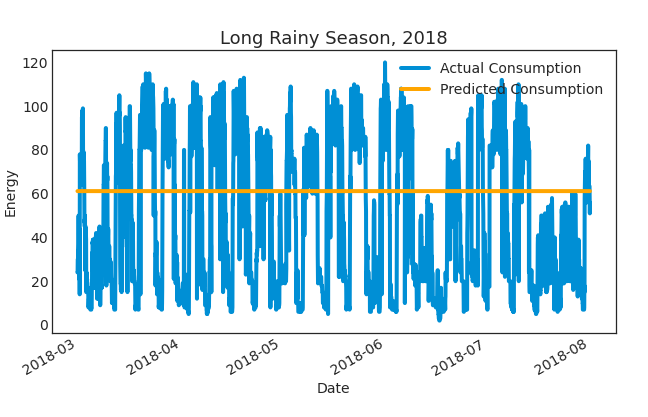

In [25]:
plot_seasonal(test, predicted_data)